<div style="background-color: #ccffcc; padding: 10px;">
    <h1> Tutorial 2 </h1> 
    <h2> Physics Informed Neural Networks Part 1</h2>
    <h2> Manual 1D Heat Equation Solver</h2>
</div>    

# Overview

This notebook is based on two papers: *[Physics-Informed Neural Networks: A Deep LearningFramework for Solving Forward and Inverse ProblemsInvolving Nonlinear Partial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999118307125)* and *[Hidden Physics Models:  Machine Learning of NonlinearPartial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999117309014)* with the help of  Fergus Shone and Michael Macraild.

These tutorials will go through solving Partial Differential Equations using Physics Informed Neural Networks focusing on the Burgers Equation and a more complex example using the Navier Stokes Equation

**This introduction section is replicated in all PINN tutorial notebooks (please skip if you've already been through)** 


    

</div>

<div style="background-color: #ccffcc; padding: 10px;">

<h1>Physics Informed Neural Networks</h1>

For a typical Neural Network using algorithms like gradient descent to look for a hypothesis, data is the only guide, however if the data is noisy or sparse and we already have governing physical models we can use the knowledge we already know to optimize and inform the algorithms. This can be done via [feature engineering]() or by adding a physical inconsistency term to the loss function.


<a href="https://towardsdatascience.com/physics-guided-neural-networks-pgnns-8fe9dbad9414">
<img src="https://miro.medium.com/max/700/1*uM2Qh4PFQLWLLI_KHbgaVw.png">
</a>   
 
 
## The very basics

If you know nothing about neural networks there is a [toy neural network python code example](https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS/tree/main/ToyNeuralNetwork) included in the [LIFD ENV ML Notebooks Repository]( https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS). Creating a 2 layer neural network to illustrate the fundamentals of how Neural Networks work and the equivalent code using the python machine learning library  [pytorch](https://pytorch.org/).

    
## Recommended reading
    
The in-depth theory behind neural networks will not be covered here as this tutorial is focusing on application of machine learning methods. If you wish to learn more here are some great starting points.  
 

* [All you need to know on Neural networks](https://towardsdatascience.com/nns-aynk-c34efe37f15a) 
* [Introduction to Neural Networks](https://victorzhou.com/blog/intro-to-neural-networks/)
* [Physics Guided Neural Networks](https://towardsdatascience.com/physics-guided-neural-networks-pgnns-8fe9dbad9414)
* [Maziar Rassi's Physics informed GitHub web Page](https://maziarraissi.github.io/PINNs/)

</div>


<hr>


<div style="background-color: #e6ccff; padding: 10px;">
    
<h1> Machine Learning Theory </h1>
<a href="https://victorzhou.com/series/neural-networks-from-scratch/">
<img src="https://victorzhou.com/media/nn-series/network.svg">
</a>

    
## Physics informed Neural Networks

Neural networks work by using lots of data to calculate weights and biases from data alone to minimise the loss function enabling them to act as universal function approximators. However these lose their robustness when data is limited. However by using known physical laws or empirical validated relationships the solutions from neural networks can be sufficiently constrained by disregarding no realistic solutions.
    
A Physics Informed Neural Network considers a parameterized and nonlinear partial differential equation in the general form;



    
\begin{align}
     u_t + \mathcal{N}[u; \lambda] &= 0, && x \in \Omega, t \in [0,T],\\
\end{align}
    


where $\mathcal{u(t,x)}$ denotes the hidden solution, $\mathcal{N}$ is a nonlinear differential operator acting on $u$, $\mathcal{\lambda}$ and $\Omega$ is a subset of $\mathbb{R}^D$ (the prescribed data). This set up an encapsulation of a wide range of problems such as diffusion processes, conservation laws,  advection-diffusion-reaction  systems,  and  kinetic  equations and conservation laws.

Here we will go though this for the 1 Heat equation and Navier stokes equations


</div>    

<div style="background-color: #cce5ff; padding: 10px;">

<h1> Python </h1>

## Pytorch
    
There are many machine learning python libraries available, [Pytorch](https://pytorch.org/) a is one such library. If you have GPUs on the machine you are using Pytorch will automatically use them and run the code even faster! This will work automatically with google co-lab if using your own machine please ensure that the GPU enabled pytorch is installed 


## Further Reading

* [Running Jupyter Notebooks](https://jupyter.readthedocs.io/en/latest/running.html#running)
* [PyTorch optimizers](https://nbviewer.org/github/bentrevett/a-tour-of-pytorch-optimizers/blob/main/a-tour-of-pytorch-optimizers.ipynb)


</div>
    
<hr>

<div style="background-color:  #f4b85d; padding: 10px;">
    
<h1> Requirements </h1>

These notebooks should run with the following requirements satisfied

<h2> Python Packages: </h2>

* Python 3
* PyTorch
* NumPy 
* Matplotlib
* SciPy

    
</div>


**Contents:**

1. **1D Heat Equation Non ML Example**
2. 1D Heat Equation PINN Example
3. Navier-Stokes PINNs discovery of PDEs


<div style="background-color: #cce5ff; padding: 10px;">
Load in all required modules (including some auxiliary code) and turn off warnings.
</div>

In [1]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from time import time
import scipy.sparse as sp
import scipy.sparse.linalg as la

<div style="background-color: #ccffcc; padding: 10px;">

<h1> 1D Heat Equation (forwards) </h1>

Given
- the initial temperature profile $u(x,0) = m(x)$,
- the thermal diffusivity $k$,
- a prescribed temperature $u(0,t) = u(L,t) = 0$ at the extremities of the rod;

solve the heat equation

\begin{equation}
\begin{array}{ll}
\frac{\partial u}{\partial t} - k \frac{\partial^2}{\partial x^2} u = 0 & \forall x\,\in\,(0, L)\; \forall t \in (0,T)\\
u(x, 0) = m(x) & \forall x \in [0,L] \\
u(0,t) = u(L,t) = 0 & \forall t \in (0, T],
\end{array}
\end{equation}

and observe the temperature at the final time $T$:


\begin{equation} \mathcal{F}(m) = u(x, T). \end{equation}

#### Analytical solution to the forward problem.
    
If

\begin{equation} m(x) = \sum_n A_n \, \sin\left(n\, \frac{\pi}{L} x \right), \quad n = 1,2,3, \ldots ,\end{equation}

then

\begin{equation} u(x,t) = \sum_n A_n e^{ -k\left(n\, \frac{\pi}{L} \right)^2 t} \sin\left(n\,\frac{\pi}{L} x \right) \end{equation}

is the unique solution to the heat equation.



<h1> 1D Heat Equation (inverse) </h1>

Given the forward model $\mathcal{F}$ and noisy measurements of the temperature profile at time T, find the initial temperature profile $m(x)$.

</div>

<hr>
<div style="background-color: #ccffcc; padding: 10px;">

    
### Discretization

To discretize the problem, we use finite differences in space and Implicit Euler in time.

#### Semidiscretization in space
We divide the $[0, L]$ interval in $n_x$ subintervals of the same length $h = \frac{L}{n_x}$, and we denote with $u_j(t) := u( jh, t)$ the value of the temperature at point $x_j = jh$ and time $t$.

We then use a centered finite difference approximation of the second derivative in space and write

\begin{equation} \frac{\partial u_j(t)}{\partial t} - k \frac{u_{j-1}(t) - 2u_j(t) + u_{j+1}(t)}{h^2} \quad \text{for } j=1,2,\ldots,n_x-1, \end{equation}

with the boundary condition $u_0(t) = u_{n_x}(t) = 0$.

By letting

\begin{equation} \mathbf{u}(t) = \begin{bmatrix}u_1(t)\\u_2(t)\\ \ldots\\ u_{n_x-1}(t) \end{bmatrix}\end{equation}

be the vector collecting the values of the temperature $u$ at the points $x_j = j\,h$, we then write the system of ordinary differential equations (ODEs):
$$ \frac{\partial}{\partial t} \mathbf{u}(t) + K \mathbf{u}(t) = 0,$$
where $K \in \mathbb{R}^{(n_x-1) \times (n_x-1)}$ is the tridiagonal matrix given by

\begin{equation} K = \frac{k}{h^2}\begin{bmatrix}  2 & -1 &       &        &        &    \\
                                    -1 &  2 & -1    &        &        &    \\
                                       & -1 &  2    & -1     &        &    \\
                                       &    &\ldots & \ldots & \ldots &    \\
                                       &    &       & -1     &     2  & -1 \\ 
                                       &    &       &        &     -1 & 2  \\
                     \end{bmatrix}.\end{equation}
                     
#### Time discretization
We subdivide the time interval $(0, T]$ in $n_t$ time step of size $\Delta t = \frac{T}{n_t}$.
By letting $\mathbf{u}^{(i)} = \mathbf{u}(i\,\Delta t)$ denote the discretized temperature profile at time $t_i = i\,\Delta t$, the Implicit Euler scheme reads

\begin{equation} \frac{\mathbf{u}^{(i+1)} - \mathbf{u}^{(i)}}{\Delta t} + K\mathbf{u}^{(i+1)} = 0, \quad \text{for } i=0,1,\ldots, n_t-1.\end{equation}

After simple algebraic manipulations and exploiting the initial condition $u(x,0) = m(x)$, written alternatively as $\mathbf{u}^0 = {\bf m}$,   we then obtain



\begin{equation}
\mathbf{u}^{(i+1)} = \left( I + \Delta t\, K\right)^{-1} \mathbf{u}^{(i)},
\end{equation}



or equivalently

\begin{equation} \mathbf{u}^{(i)} = \left( I + \Delta t\, K\right)^{-i} \mathbf{m}.\end{equation}


</div>

<div style="background-color: #cce5ff; padding: 10px;">

# Define some helper functions to Solve 1D heat equation forwards 

In the code below, the function `assembleMatrix` generates the finite difference matrix $\left( I + \Delta t\, K \right)$ and the function `solveFwd` evaluates the forward model

\begin{equation} F\, \mathbf{m} = \left( I + \Delta t\, K\right)^{-n_t}\, \mathbf{m}. \end{equation}
    
</div>

In [3]:
def plot(f, style, **kwargs):
    x = np.linspace(0., L, nx+1)
    f_plot = np.zeros_like(x)
    f_plot[1:-1] = f
    plt.plot(x,f_plot, style, **kwargs)
    
def assembleMatrix(n):
    diagonals = np.zeros((3, n))   # 3 diagonals
    diagonals[0,:] = -1.0/h**2
    diagonals[1,:] =  2.0/h**2
    diagonals[2,:] = -1.0/h**2
    K = k*sp.spdiags(diagonals, [-1,0,1], n,n)
    M = sp.spdiags(np.ones(n), 0, n,n)
    
    return M + dt*K
    

def solveFwd(m):
    A = assembleMatrix(m.shape[0])
    u_old = m.copy()
    for i in np.arange(nt):
        u = la.spsolve(A, u_old)
        u_old[:] = u
        
    return u        

<hr>
<div style="background-color: #ccffcc; padding: 10px;">
    
### A naive solution to the inverse problem

If ${F}$ is invertible, a direct but naive solution to the inverse problem ${F} {\bf m} = {\bf d}$ is simply to find

\begin{equation} {\bf m} = {F}^{-1} {\bf d}. \end{equation}


    
</div>
<div style="background-color: #cce5ff; padding: 10px;">

The function `naiveSolveInv` computes the solution of the discretized inverse problem $\mathbf{m} = F^{-1} \mathbf{d}$ as

\begin{equation} \mathbf{m} = \left( I + \Delta t\,K\right)^{n_t} \mathbf{d}. \end{equation}



    
</div>

In [4]:
def naiveSolveInv(d):
    A = assembleMatrix(d.shape[0])
    
    p_i = d.copy()
    for i in np.arange(nt):
        p = A*p_i
        p_i[:] = p
        
    return p

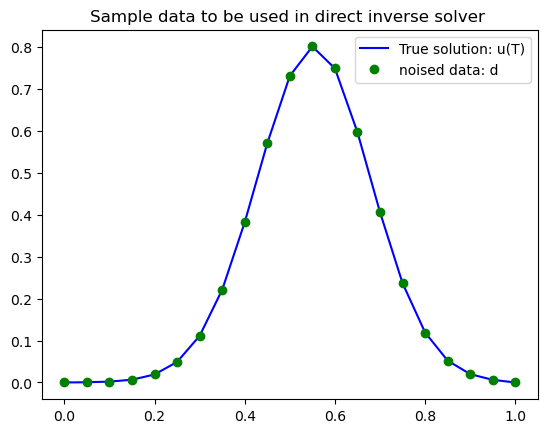

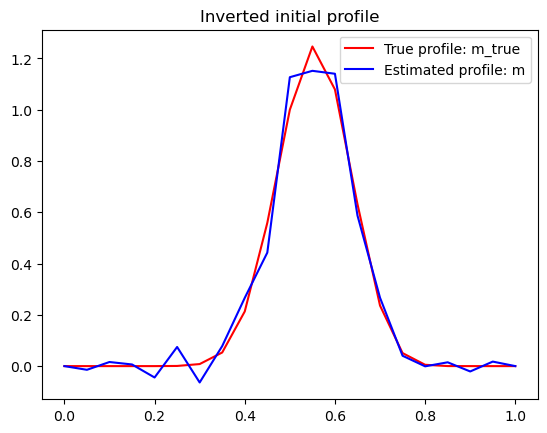

In [8]:
# Edit nx or noise_std_dev to see the impact on the naive solver

nx = 20 # default 20
noise_std_dev = 1e-4 # default


T = 1.0
L = 1.0
k = 0.005

nt = 100


h = L/float(nx)
dt = T/float(nt)

x = np.linspace(0.+h, L-h, nx-1) # place nx-1 equispace point in the interior of [0,L] interval
m_true = np.power(.5,-36)*np.power(x,20)*np.power(1. - x, 16)  # smooth true initial condition
# m_true = 0.5 - np.abs(x-0.5)                                    # initial condition with a corner
u_true = solveFwd(m_true)

d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

m = naiveSolveInv(d)

plot(u_true, "-b", label = 'True solution: u(T)')
plot(d, "og", label = 'noised data: d')
plt.legend()
plt.title('Sample data to be used in direct inverse solver ')
plt.show()


plot(m_true, "-r", label = 'True profile: m_true')
plot(m, "-b", label = 'Estimated profile: m')
plt.legend()
plt.title('Inverted initial profile')
plt.show()


<div style="background-color: #cce5ff; padding: 10px;">

If you have played around with the code above you will see that:
- for a very coarse mesh (`nx = 20`) and no measurement noise (`noise_std_dev = 0.0`) the naive solution is quite good
- for a finer mesh (`nx = 100`) and/or even small measurement noise (`noise_std_dev = 0.0001`) the naive solution is very poor

</div>    

<hr>
<div style="background-color: #ccffcc; padding: 10px;">
    
### Why does the naive solution fail?

Let 

\begin{equation}v_n = \sqrt{\frac{2}{L}} \sin\left( n \, \frac{\pi}{L} x \right)\end{equation} 

with n=1,2,3, then we have that

\begin{equation} \mathcal{F} v_n = \lambda_n v_n, \quad \text{where the eigenvalues } \lambda_n = e^{-kT\left(\frac{\pi}{L} n \right)^2}. \end{equation}

It follows that the discretised matrix $F$ has similar eigenvalues.

**Note 1**:
- Large eigenvalues $\lambda_n$ correspond to smooth eigenfunctions $v_n$;
- Small eigenvalues $\lambda_n$ correspond to oscillatory eigenfuctions $v_n$.

The figure below shows that the eigenvalues $\lambda_n$ **decay** extremely fast with index. This means that the inverse of the matrix has eigenvalues that **grow** extremely fast with index, making the inverse matrix $F^{-1}$ (where $F$ is the discretization of the forward model) extremely ill conditioned for inverse problems.

</div>

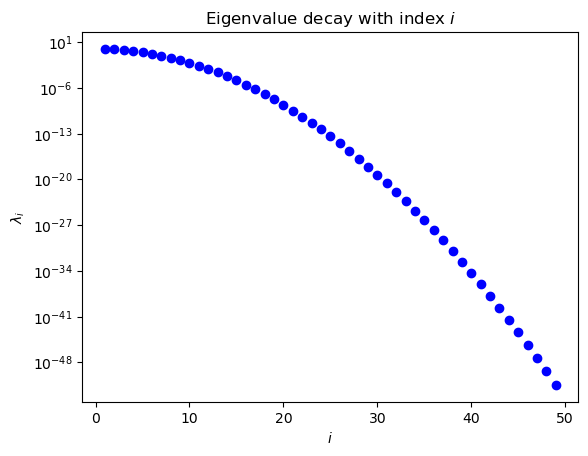

In [9]:
T = 1.0
L = 1.0
k = 0.005

i = np.arange(1,50)
lambdas = np.exp(-k*T*np.power(np.pi/L*i,2))

plt.semilogy(i, lambdas, 'ob')
plt.xlabel(r'$i$')
plt.ylabel(r'$\lambda_i$')
plt.title('Eigenvalue decay with index $i$')
plt.show()

<hr>
<div style="background-color: #ccffcc; padding: 10px;">
    
**Note 2**: The functions $v_n$ ($n=1,2,3, \ldots$) form an orthonormal basis of $L^2([0,1]$). 

That is, every function $f \in L^2([0,1])$ can be written as

\begin{equation} f = \sum_{n=1}^\infty \alpha_n v_n, \text{ where } \alpha_n = \int_0^1 f v_n dx.\end{equation}

Consider now the noisy problem

\begin{equation} d = \mathcal{F}m_{\rm true} + \eta, \end{equation}

where
- $d$ is the data (noisy measurements)
- $\eta$ is the noise which we write like this: $\eta(x) = \sum_{n=1}^\infty \eta_n v_n(x)$
- $m_{\rm true}$ is the true initial profile 
- $\mathcal{F}$ is the forward heat equation

Then, the naive solution to the inverse problem $\mathcal{F}m = d$ is

\begin{equation} m = \mathcal{F}^{-1}d = \mathcal{F}^{-1}\left( \mathcal{F}m_{\rm true} + \eta \right) = m_{\rm true} + \mathcal{F}^{-1} \eta = m_{\rm true} + \mathcal{F}^{-1} \sum_{n=1}^{\infty} \eta_n v_n = m_{\rm true} +  \sum_{n=1}^{\infty} \frac{\eta_n}{\lambda_n} v_n. \end{equation}

If the coefficients $\eta_n = \int_0^1 \eta(x) \, v_n(x) \, dx$ do not decay sufficiently fast compared to the eigenvalues $\lambda_n$, then the naive solution is unstable.

The main issue is that the approach is designed to satisfy exactly the equation (which is ill-conditioned for the inverse problem). 
An alternative is to soften this constraint, for which we might consider looking to PINNs.

<hr>

<div style="background-color: #e6ccff; padding: 10px;">

## Next steps

Now we've gone through a naive approach to solving a simple 1D Heat equation, we look at the benefits of using neural networks to solve an equivalent problem.
    
</div>